In [0]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
import os
import zipfile
from tensorflow.keras import layers
from tensorflow.keras import Model
import tensorflow as tf

In [0]:
local_zip = '//tmp/Toxicity Classification transfer learning - New image.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/Toxicity Classification transfer learning - New image'

In [0]:
pre_trained_model = VGG16(input_shape = (224, 224, 3), 
                                include_top = False, 
                                weights = 'imagenet')

In [0]:
pre_trained_model = InceptionV3(input_shape = (224, 224, 3), 
                                include_top = False, 
                                weights = 'imagenet')

In [0]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [0]:
pre_trained_model.summary()

In [5]:
# VGG16
last_layer = pre_trained_model.get_layer('block5_pool')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 512)


In [0]:
# InceptionV3
last_layer = pre_trained_model.get_layer('mixed10')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 5, 5, 2048)


In [0]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
#x = layers.Flatten()(last_output)
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(4096, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(4096, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a fully connected layer with 1,024 hidden units and ReLU activation
#x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
#x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

for layer in pre_trained_model.layers:
  layer.trainable = False

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc',tf.keras.metrics.AUC(),tf.keras.metrics.Precision(),
                         tf.keras.metrics.Recall(),
                         tf.keras.metrics.SpecificityAtSensitivity(0.9)])

In [0]:
# Define our example directories and files
base_dir = '/tmp/Toxicity Classification transfer learning - New image'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_nontoxicity_dir = os.path.join(train_dir, 'nontoxicity') # Directory with our training nontoxicity pictures
train_toxicity_dir = os.path.join(train_dir, 'toxicity') # Directory with our training toxicity pictures
validation_nontoxicity_dir = os.path.join(validation_dir, 'nontoxicity') # Directory with our validation nontoxicity pictures
validation_toxicity_dir = os.path.join(validation_dir, 'toxicity')# Directory with our validation toxicity pictures

train_nontoxicity_fnames = os.listdir(train_nontoxicity_dir)
train_toxicity_fnames = os.listdir(train_toxicity_dir)

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (224, 224))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 1,
                                                          class_mode  = 'binary', 
                                                          target_size = (224, 224))

Found 527 images belonging to 2 classes.
Found 28 images belonging to 2 classes.


In [0]:
classes_weight = {0:1,
                  1:1}

In [0]:
class myCallback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_acc') > 0.85):
          if(logs.get('val_loss') < 0.2):
            if(logs.get('val_auc') > 0.9):
              if(logs.get('acc') > 0.95):
                print("\nReached 85% accuracy for validation, so cancelling training!")
                self.model.stop_training = True

callbacks = myCallback()

In [11]:
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 20,
            epochs = 200,
            validation_steps = 7,
            verbose = 1,
            callbacks = [callbacks],
            class_weight = classes_weight)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
20/20 [==============================] - 6s 305ms/step - loss: 1.9071 - acc: 0.5100 - auc: 0.5205 - precision: 0.5368 - recall: 0.4857 - specificity_at_sensitivity: 0.1105 - val_loss: 1.0026 - val_acc: 0.2857 - val_auc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_specificity_at_sensitivity: 0.5000
Epoch 2/200
20/20 [==============================] - 5s 268ms/step - loss: 0.7321 - acc: 0.6253 - auc: 0.6605 - precision: 0.5838 - recall: 0.5805 - specificity_at_sensitivity: 0.2113 - val_loss: 0.6778 - val_acc: 0.5714 - val_auc: 0.9167 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_specificity_at_sensitivity: 0.0000e+00
Epoch 3/200
20/20 [==============================] - 5s 259ms/step - loss: 0.6795 - acc: 0.6408 - auc: 0.6907 - precision: 0.6650 - recall: 0.6553 - specificity_at_sensitivity: 0.2707 - val_loss: 1.0069 - val_acc: 0.4286 - val_auc: 0.9167 - val_precision

14 real toxicity in validation, their augmentation in training. Best models:
Fully connected layers: 2048, 1024
epochs: 100
loss: 0.0444 - acc: 0.9875 - auc: 0.9989 - precision: 0.9947 - recall: 0.9793 - val_loss: 0.2452 - val_acc: 0.8571 - val_auc: 1.0000 - val_precision: 1.0000 - val_recall: 0.7143

Fully connected layers: 2048, 1024, 1024
epochs: 200
loss: 0.0931 - acc: 0.9638 - auc_1: 0.9935 - precision_1: 0.9701 - recall_1: 0.9606 - val_loss: 0.1719 - val_acc: 0.8571 - val_auc_1: 0.9541 - val_precision_1: 0.8125 - val_recall_1: 0.9286

Fully connected layers: 4096, 4096
loss: 0.0843 - acc: 0.9675 - auc: 0.9934 - precision: 0.9612 - recall: 0.9754 - specificity_at_sensitivity: 0.9797 - val_loss: 0.1389 - val_acc: 1.0000 - val_auc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_specificity_at_sensitivity: 0.0000e+00

7 hold out best model: 
1. fully connected layer: 1024
loss: 0.3234 - acc: 0.8582 - auc_2: 0.9319 - precision_2: 0.8564 - recall_2: 0.8424 - val_loss: 0.5651 - val_acc: 0.7857 - val_auc_2: 0.7832 - val_precision_2: 0.8333 - val_recall_2: 0.7143
2. fully connected layer: 4096
loss: 0.0937 - acc: 0.9794 - auc: 0.9945 - precision: 0.9755 - recall: 0.9851 - val_loss: 0.1877 - val_acc: 0.8571 - val_auc: 1.0000 - val_precision: 1.0000 - val_recall: 0.5000

In [0]:
model.predict_generator(validation_generator,steps=28)

NameError: ignored

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, 28)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['nontoxicity', 'toxicity']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[14  0]
 [14  0]]
Classification Report
              precision    recall  f1-score   support

 nontoxicity       0.50      1.00      0.67        14
    toxicity       0.00      0.00      0.00        14

    accuracy                           0.50        28
   macro avg       0.25      0.50      0.33        28
weighted avg       0.25      0.50      0.33        28



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 432x288 with 0 Axes>

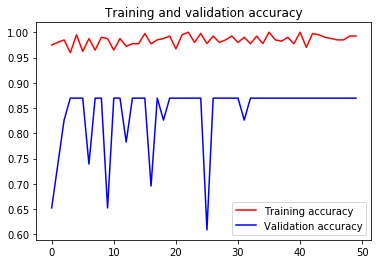

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()